In [2]:
from CRNN_config import *

import os
import sys
import pickle
import time


import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from collections import defaultdict


save_dict = True
word_freq_path =  'word_freq.pk'

load_word2vec = True
word2vec_path = 'word2vec.bin'

load_model_bool = False
model_path = 'CRNN_1st.h5'

nolabel = np.load("/home/derricksu/ML_data/hw4/train_nolabel.npy")
train_path = "/home/derricksu/ML_data/hw4/train.npy"
train = np.load(train_path)
test_path = "/home/derricksu/ML_data/hw4/test.npy"
test = np.load(test_path)
predict_path = "/home/derricksu/pred/best.csv"

"""
## for homework
train_path = sys.argv[1]
train=load_data(train_path,train=True)

nolabel_path = sys.argv[2]
nolabel = load_nolabel(nolabel_path)

test_path = sys.argv[1]
test = load_data(test_path,train=False)

predict_path = sys.argv[2]
"""


# Record frequency of each word
word_freq=defaultdict(int)

# nolabel
sentence = []
for row in nolabel:
    x = text_to_wordlist(row).split()
    sentence.append(x)
    for s in x:
        word_freq[s]+=1

print("After nolabel: %d" % len(word_freq))

# label
X_data = train[:,1]
y_data = train[:,0].astype('int')


train_sentence = []

for i,row in enumerate(X_data):
    x = text_to_wordlist(row).split()
    train_sentence.append(x)
    for s in x:
        word_freq[s]+=1
print("After label: %d" % len(word_freq))

test_sentence = []
for i,row in enumerate(test[1::,1]): #第一列不為name
    x = text_to_wordlist(row).split()
    test_sentence.append(x)
    for s in x:
        word_freq[s]+=1
print("After test: %d" % len(word_freq))




# produce word_freq
if save_dict:
    with open(word_freq_path,"wb") as pk:
        pickle.dump( word_freq,pk )
        pk.close()
else:
    with open(word_freq_path,"rb") as pk:
        word_freq = pickle.load(pk)
        pk.close()
print("word_freq is already")


# produce word2vec
if not load_word2vec:
    w2v_st_time=time.time()
    print("train word2vec...") 
    # sg defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed. window=12
    my_word2vec = Word2Vec(sentence + train_sentence + test_sentence, sg = 0,#window=15,
                           iter=30, min_count=min_c,size=128,workers=16)
    w2v_fi_time=time.time()
    # summarize the loaded model
    print(my_word2vec)
    # summarize vocabulary
    words = list(my_word2vec.wv.vocab)
    #print(words)
    # access vector for one word
    print(my_word2vec['sentence'].shape)
    # save model
    my_word2vec.save(word2vec_path)
else:
    print("load model...") 
    my_word2vec = Word2Vec.load(word2vec_path)
    #print(my_word2vec)

vocab = dict([(k, v.index) for k, v in my_word2vec.wv.vocab.items()])
weight_matrix = my_word2vec.wv.syn0 #word_to_vec
print("Weight_matrix shape : " , weight_matrix.shape)
del my_word2vec
print("word2vec is already.")


# word to idx of train
train_word2idx=[]
for row in train_sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    train_word2idx.append(idx)

print("Length of train_sentence : ",len(train_sentence))
print("Length of train_word2idx : ",len(train_word2idx))

max_len = 0
for row in train_word2idx:
    if max_len <len(row):
        max_len = len(row)
print("Max length of train sentence : ",max_len)

# word to idx of test
test_word2idx=[]
for row in test_sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    test_word2idx.append(idx)
print("Length of test_sentence : ",len(test_sentence))
print("Length of test_word2idx : ",len(test_word2idx))

max_len = 0
for row in train_word2idx:
    if max_len <len(row):
        max_len = len(row)
print("Max length of test sentence : ",max_len)



#import keras
from keras import utils

from keras.models import load_model


Y_train = utils.to_categorical(y_data ,2)
X_train = train_word2idx
X_test = test_word2idx


max_review_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

n_batch = 256
n_epoch = 10

if load_model_bool:
    model = load_model(model_path)
else:
    from keras.callbacks import EarlyStopping , History
    model_st_time=time.time()
    model = build(weight_matrix,vocab,max_review_length)

    earlystopping=EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=0, mode='auto')
    history = History()

    hist_lstm = model.fit(X_train , Y_train ,
                          batch_size = n_batch,epochs=n_epoch,
                          callbacks=[earlystopping,history],
                          validation_split=0.1)

    model_fi_time=time.time()
    
"""    
pred_y = model.predict(X_test,batch_size=n_batch)
print("Shape of predict of test : ",pred_y.shape)

with open(predict_path , "w" , encoding = "utf-8") as f :
    f.write("id,label\n")
    for i ,pre in enumerate(pred_y):
        f.write( "{0},{1}\n".format( i , np.argmax(pre) ) )
    f.close()
"""
print("Finish.")

After nolabel: 229942
After label: 235886
After test: 241746
word_freq is already
load model...
Weight_matrix shape :  (78522, 128)
word2vec is already.
Length of train_sentence :  200000
Length of train_word2idx :  200000
Max length of train sentence :  95
Length of test_sentence :  200000
Length of test_word2idx :  200000
Max length of test sentence :  95
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 100, 128)      10050816    input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,val_acc,acc,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 2/10
180000/180000 [==============================] - 360s - loss: 0.4168 - acc: 0.8107 - val_loss: 0.4054 - val_acc: 0.8176
Epoch 3/10
180000/180000 [==============================] - 356s - loss: 0.3871 - acc: 0.8282 - val_loss: 0.4163 - val_acc: 0.8103
Epoch 4/10
180000/180000 [==============================] - 354s - loss: 0.3578 - acc: 0.8423 - val_loss: 0.4054 - val_acc: 0.8185
Epoch 5/10
180000/180000 [==============================] - 354s - loss: 0.3297 - acc: 0.8578 - val_loss: 0.4196 - val_acc: 0.8169
Epoch 6/10
180000/180000 [==============================] - 352s - loss: 0.2965 - acc: 0.8747 - val_loss: 0.4794 - val_acc: 0.8096
Epoch 7/10
115200/180000 [==================>...........] - ETA: 122s - loss: 0.2635 - acc: 0.8892

KeyboardInterrupt: 

In [4]:
from keras.callbacks import EarlyStopping , History
model_st_time=time.time()
model = build(weight_matrix,vocab,max_review_length)

earlystopping=EarlyStopping(monitor='val_acc', patience=3, verbose=0, mode='auto')
history = History()

hist_lstm = model.fit(X_train , Y_train ,
                      batch_size = n_batch,epochs=n_epoch,
                      callbacks=[earlystopping,history],
                      validation_split=0.1)

model_fi_time=time.time()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 100, 128)      10050816    input_4[0][0]                    
____________________________________________________________________________________________________
conv1d_10 (Conv1D)               (None, 96, 96)        61536       embedding_4[0][0]                
____________________________________________________________________________________________________
conv1d_11 (Conv1D)               (None, 92, 96)        110688      embedding_4[0][0]                
___________________________________________________________________________________________

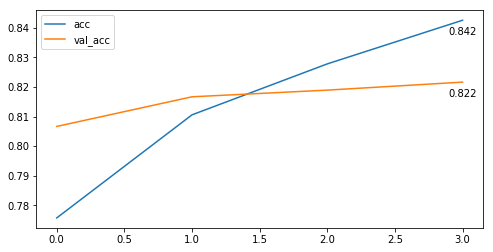

In [12]:
import matplotlib.pyplot as plt

hist_dict = hist_lstm.history

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for key in ['acc' , 'val_acc']:
    y = hist_dict[key]
    ax.plot(y[0:4],label=key)
    max_index = 3
    ax.annotate('{0:.3f}'.format(y[max_index]) , xy =(max_index , y[max_index]-0.005),horizontalalignment='center' )

plt.legend()    
plt.show()

In [2]:
print("time for training a word2vec  :",w2v_fi_time-w2v_st_time)
print("time for training a RNN model :",model_fi_time-model_st_time)


461.07216715812683

## 請說明你實作的 BOW model，其模型架構、訓練過程和準確率為何？

In [30]:
import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

max_words = 10000 #241746
batch_size = 32
epochs = 5

print('Loading data...')
x_train = X_data
y_train = y_data
x_test = test[1::,1]
print(len(x_test), 'test sequences')

num_classes = 2
print(num_classes, 'classes')

print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_matrix(x_train, mode='binary')
x_test = tokenizer.texts_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('Building model...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)



Loading data...
200000 test sequences
2 classes
Vectorizing sequence data...
x_train shape: (200000, 10000)
x_test shape: (200000, 10000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (200000, 2)
y_test shape: (2246, 46)
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 512)               5120512   
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_12 (Activation)   (None, 256)        

AttributeError: 'Sequential' object has no attribute 'pridect'

In [31]:
pred_y = model.predict(x_test,
                       batch_size=batch_size, verbose=1)

predict_path='/home/derricksu/pred/BOW.csv'
with open(predict_path , "w" , encoding = "utf-8") as f :
    f.write("id,label\n")
    for i ,pre in enumerate(pred_y):
        f.write( "{0},{1}\n".format( i , np.argmax(pre) ) )
    f.close()

199712/200000 [============================>.] - ETA: 0s

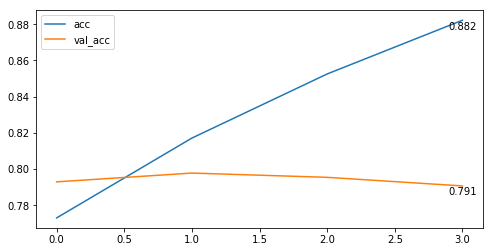

In [32]:
import matplotlib.pyplot as plt

hist_dict = history.history

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for key in ['acc' , 'val_acc']:
    y = hist_dict[key]
    ax.plot(y[0:4],label=key)
    max_index = 3
    ax.annotate('{0:.3f}'.format(y[max_index]) , xy =(max_index , y[max_index]-0.005),horizontalalignment='center' )

plt.legend()    
plt.show()

In [49]:
def RNN(weight_matrix , vocab,max_review_length):
    embedding_vecor_length = weight_matrix.shape[1]
    word_total_index = len(vocab)

    forget_bias_bool=True #default is False
    recu_drop_rate=0.2
    drop_rate=0.2
    back_bool=False #default False
    unroll_bool=True #default is False. This can speed up but consume more memory
    multi_layer_bool=True #default False

    model = Sequential()
    model.add(Embedding(word_total_index, embedding_vecor_length, input_length=max_review_length,
                       weights = [weight_matrix]))
    
    model.add(LSTM(128,
                  unit_forget_bias=forget_bias_bool,
                  recurrent_dropout=recu_drop_rate,
                  dropout=drop_rate,
                  go_backwards=back_bool,
                  unroll=unroll_bool,
                  return_sequences=multi_layer_bool )) 
                   # Control output of this layer , return a decoded sequence whose dimension is same as input
    model.add(Dropout(0.2))
    
    model.add(LSTM(256,
                  unit_forget_bias=forget_bias_bool,
                  recurrent_dropout=recu_drop_rate,
                  dropout=drop_rate,
                  go_backwards=False,
                  unroll=unroll_bool))
    model.add(Dropout(0.2))

    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    print(model.summary())

    return model


model_rnn = RNN(weight_matrix , vocab,max_review_length)
n_batch = 256
n_epoch = 10

earlystopping=EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=0, mode='auto')
history = History()

hist_rnn= model_rnn.fit(X_train , Y_train ,
                      batch_size = n_batch,epochs=5,
                      callbacks=[earlystopping,history],
                      validation_split=0.1)

pred_y = model_rnn.predict(X_test,batch_size=n_batch)
print("Shape of predict of test : ",pred_y.shape)
predict_path = "/home/derricksu/pred/lstm_12_7.csv"

with open(predict_path , "w" , encoding = "utf-8") as f :
    f.write("id,label\n")
    for i ,pre in enumerate(pred_y):
        f.write( "{0},{1}\n".format( i , np.argmax(pre) ) )
    f.close()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 128)          10050816  
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 128)          131584    
_________________________________________________________________
dropout_41 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_43 (Dropout)         (None, 512)               0         
__________

In [51]:
model_rnn.save("lstm_best.h5")

In [52]:
plot_model(model_rnn,tofile='lstm.png')

NameError: name 'plot_model' is not defined

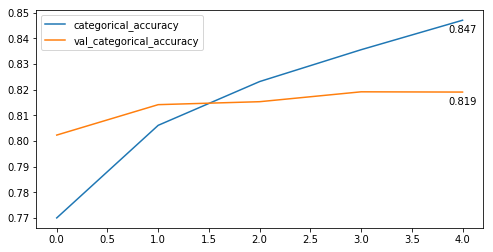

In [55]:

import matplotlib.pyplot as plt

hist_dict = hist_rnn.history

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for key in ['categorical_accuracy' , 'val_categorical_accuracy']:
    y = hist_dict[key]
    ax.plot(y,label=key)
    max_index = 4
    ax.annotate('{0:.3f}'.format(y[max_index]) , xy =(max_index , y[max_index]-0.005),horizontalalignment='center' )

plt.legend()    
plt.show()

## 請比較bag of word與RNN兩種不同model對於"today is a good day, but it is hot"與"today is hot, but it is a good day"這兩句的情緒分數，並討論造成差異的原因。

In [43]:
def proce(nolabel,word_freq,vocab):
    min_c = 3
    sentence = []
    for row in nolabel:
        x = text_to_wordlist(row).split()
        sentence.append(x)
    train_word2idx=[]
    for row in sentence:
        idx = []
        for word in row:
            if word_freq[word]>=min_c:
                idx.append(vocab[word])
        train_word2idx.append(idx)
    train_word2idx = sequence.pad_sequences(train_word2idx, maxlen=max_review_length)
    return train_word2idx

In [44]:
hw=["today is a good day, but it is hot","today is hot, but it is a good day"]

hw_bow = tokenizer.texts_to_matrix(hw, mode='binary')

hw_rnn = proce(hw,word_freq,vocab)

vec_bow = model.predict(hw_bow)

vec_rnn = model_rnn.predict(hw_rnn)


In [48]:
hw_bow.max()

1.0

In [45]:
vec_bow

array([[ 0.38304621,  0.61695379],
       [ 0.38304621,  0.61695379]], dtype=float32)

In [46]:
vec_rnn

array([[ 0.3894341 ,  0.6105659 ],
       [ 0.01503595,  0.98496407]], dtype=float32)

In [1]:
from CRNN_config_nocomma import *

Using TensorFlow backend.


In [ ]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False,comma=True):
    # Clean the text, with the option to remove stopwords and to stem words.
    import re
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    if not comma:
        text = re.sub(r"[,+\$&^!:;.\/'-=?]", " ", text) # origin is [^A-Za-z0-9^,!.\/'+-=?]
    else:
        pass
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return text


In [56]:
text_to_wordlist("wer qwe qw 123 &&$$ ''^^: ,12d3 , ,+  ,",comma=True)

"wer qwe qw 123 &&$$ ''^^: ,12d3 , ,+ ,"

In [54]:
import re
text = "1234 gs__df*\ ><,."
re.sub(r"[,:\\\/\_^.$%#><+-/\?\=*]", " ", text)

'1234 gs  df       '

## 比較有無標點符號

In [2]:
## 有標點符號

from CRNN_config_nocomma import *

import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from collections import defaultdict


save_dict = False
word_freq_path =  'word_freq.pk'

load_word2vec = False
word2vec_path = 'word2vec.bin'

load_model_bool = False
model_path = 'CRNN_1st.h5'

nolabel = np.load("/home/derricksu/ML_data/hw4/train_nolabel.npy")
train_path = "/home/derricksu/ML_data/hw4/train.npy"
train = np.load(train_path)
test_path = "/home/derricksu/ML_data/hw4/test.npy"
test = np.load(test_path)
predict_path = "/home/derricksu/pred/withcamma.csv"

"""
## for homework
train_path = sys.argv[1]
train=load_data(train_path,train=True)

nolabel_path = sys.argv[2]
nolabel = load_nolabel(nolabel_path)

test_path = sys.argv[1]
test = load_data(test_path,train=False)

predict_path = sys.argv[2]
"""


# Record frequency of each word
word_freq=defaultdict(int)

# nolabel
sentence = []
for row in nolabel:
    x = text_to_wordlist(row,comma=True).split()
    sentence.append(x)
    for s in x:
        word_freq[s]+=1

print("After nolabel: %d" % len(word_freq))

# label
X_data = train[:,1]
y_data = train[:,0].astype('int')


train_sentence = []

for i,row in enumerate(X_data):
    x = text_to_wordlist(row,comma=True).split()
    train_sentence.append(x)
    for s in x:
        word_freq[s]+=1
print("After label: %d" % len(word_freq))

test_sentence = []
for i,row in enumerate(test[1::,1]): #第一列不為name
    x = text_to_wordlist(row,comma=True).split()
    test_sentence.append(x)
    for s in x:
        word_freq[s]+=1
print("After test: %d" % len(word_freq))


print("word_freq is already")


# produce word2vec
if not load_word2vec:
    print("train word2vec...") 
    # sg defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed. window=12
    my_word2vec = Word2Vec(sentence + train_sentence + test_sentence, sg = 0,#window=15,
                           iter=30, min_count=min_c,size=128,workers=16)
    # summarize the loaded model
    print(my_word2vec)
    # summarize vocabulary
    words = list(my_word2vec.wv.vocab)
    #print(words)
    # access vector for one word
    print(my_word2vec['sentence'].shape)
    # save model
    #my_word2vec.save(word2vec_path)
else:
    print("load model...") 
    my_word2vec = Word2Vec.load(word2vec_path)
    #print(my_word2vec)

vocab = dict([(k, v.index) for k, v in my_word2vec.wv.vocab.items()])
weight_matrix = my_word2vec.wv.syn0 #word_to_vec
print("Weight_matrix shape : " , weight_matrix.shape)
del my_word2vec
print("word2vec is already.")


# word to idx of train
train_word2idx=[]
for row in train_sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    train_word2idx.append(idx)

print("Length of train_sentence : ",len(train_sentence))
print("Length of train_word2idx : ",len(train_word2idx))

max_len = 0
for row in train_word2idx:
    if max_len <len(row):
        max_len = len(row)
print("Max length of train sentence : ",max_len)

# word to idx of test
test_word2idx=[]
for row in test_sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    test_word2idx.append(idx)
print("Length of test_sentence : ",len(test_sentence))
print("Length of test_word2idx : ",len(test_word2idx))

max_len = 0
for row in train_word2idx:
    if max_len <len(row):
        max_len = len(row)
print("Max length of test sentence : ",max_len)



#import keras
from keras import utils

from keras.models import load_model


Y_train = utils.to_categorical(y_data ,2)
X_train = train_word2idx
X_test = test_word2idx


max_review_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

n_batch = 256
n_epoch = 10


from keras.callbacks import EarlyStopping , History
model = build(weight_matrix,vocab,max_review_length)
earlystopping=EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=0, mode='auto')
history = History()

hist_lstm_1 = model.fit(X_train , Y_train ,
                      batch_size = n_batch,epochs=n_epoch,
                      callbacks=[earlystopping,history],
                      validation_split=0.1)

pred_y = model.predict(X_test,batch_size=n_batch)
print("Shape of predict of test : ",pred_y.shape)

print(predict_path)
with open(predict_path , "w" , encoding = "utf-8") as f :
    f.write("id,label\n")
    for i ,pre in enumerate(pred_y):
        f.write( "{0},{1}\n".format( i , np.argmax(pre) ) )
    f.close()
print("length of vocab : ",len(vocab))

After nolabel: 244275
After label: 250590
After test: 256792
word_freq is already
train word2vec...
Word2Vec(vocab=82670, size=128, alpha=0.025)
(128,)
Weight_matrix shape :  (82670, 128)
word2vec is already.
Length of train_sentence :  200000
Length of train_word2idx :  200000
Max length of train sentence :  40
Length of test_sentence :  200000
Length of test_word2idx :  200000
Max length of test sentence :  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          10581760  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               3

In [1]:
from CRNN_config_nocomma import *

import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from collections import defaultdict


save_dict = False
word_freq_path =  'word_freq.pk'

load_word2vec = False
word2vec_path = 'word2vec.bin'

load_model_bool = False
model_path = 'CRNN_1st.h5'

nolabel = np.load("/home/derricksu/ML_data/hw4/train_nolabel.npy")
train_path = "/home/derricksu/ML_data/hw4/train.npy"
train = np.load(train_path)
test_path = "/home/derricksu/ML_data/hw4/test.npy"
test = np.load(test_path)
predict_path = "/home/derricksu/pred/nocamma.csv"

"""
## for homework
train_path = sys.argv[1]
train=load_data(train_path,train=True)

nolabel_path = sys.argv[2]
nolabel = load_nolabel(nolabel_path)

test_path = sys.argv[1]
test = load_data(test_path,train=False)

predict_path = sys.argv[2]
"""


# Record frequency of each word
word_freq=defaultdict(int)

# nolabel
sentence = []
for row in nolabel:
    x = text_to_wordlist(row,comma=False).split()
    sentence.append(x)
    for s in x:
        word_freq[s]+=1

print("After nolabel: %d" % len(word_freq))

# label
X_data = train[:,1]
y_data = train[:,0].astype('int')


train_sentence = []

for i,row in enumerate(X_data):
    x = text_to_wordlist(row,comma=False).split()
    train_sentence.append(x)
    for s in x:
        word_freq[s]+=1
print("After label: %d" % len(word_freq))

test_sentence = []
for i,row in enumerate(test[1::,1]): #第一列不為name
    x = text_to_wordlist(row,comma=False).split()
    test_sentence.append(x)
    for s in x:
        word_freq[s]+=1
print("After test: %d" % len(word_freq))


print("word_freq is already")


# produce word2vec
if not load_word2vec:
    print("train word2vec...") 
    # sg defines the training algorithm. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed. window=12
    my_word2vec = Word2Vec(sentence + train_sentence + test_sentence, sg = 0,#window=15,
                           iter=30, min_count=min_c,size=128,workers=16)
    # summarize the loaded model
    print(my_word2vec)
    # summarize vocabulary
    words = list(my_word2vec.wv.vocab)
    #print(words)
    # access vector for one word
    print(my_word2vec['sentence'].shape)
    # save model
    #my_word2vec.save(word2vec_path)
else:
    print("load model...") 
    my_word2vec = Word2Vec.load(word2vec_path)
    #print(my_word2vec)

vocab = dict([(k, v.index) for k, v in my_word2vec.wv.vocab.items()])
weight_matrix = my_word2vec.wv.syn0 #word_to_vec
print("Weight_matrix shape : " , weight_matrix.shape)
del my_word2vec
print("word2vec is already.")


# word to idx of train
train_word2idx=[]
for row in train_sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    train_word2idx.append(idx)

print("Length of train_sentence : ",len(train_sentence))
print("Length of train_word2idx : ",len(train_word2idx))

max_len = 0
for row in train_word2idx:
    if max_len <len(row):
        max_len = len(row)
print("Max length of train sentence : ",max_len)

# word to idx of test
test_word2idx=[]
for row in test_sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    test_word2idx.append(idx)
print("Length of test_sentence : ",len(test_sentence))
print("Length of test_word2idx : ",len(test_word2idx))

max_len = 0
for row in train_word2idx:
    if max_len <len(row):
        max_len = len(row)
print("Max length of test sentence : ",max_len)



#import keras
from keras import utils

from keras.models import load_model


Y_train = utils.to_categorical(y_data ,2)
X_train = train_word2idx
X_test = test_word2idx


max_review_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

n_batch = 256
n_epoch = 10


from keras.callbacks import EarlyStopping , History
model = build(weight_matrix,vocab,max_review_length)
earlystopping=EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=0, mode='auto')
history = History()

hist_lstm_2 = model.fit(X_train , Y_train ,
                      batch_size = n_batch,epochs=n_epoch,
                      callbacks=[earlystopping,history],
                      validation_split=0.1)

pred_y = model.predict(X_test,batch_size=n_batch)
print("Shape of predict of test : ",pred_y.shape)

print(predict_path)
with open(predict_path , "w" , encoding = "utf-8") as f :
    f.write("id,label\n")
    for i ,pre in enumerate(pred_y):
        f.write( "{0},{1}\n".format( i , np.argmax(pre) ) )
    f.close()
    
print("length of vocab : ",len(vocab))

Using TensorFlow backend.


After nolabel: 230188
After label: 236099
After test: 241874
word_freq is already
train word2vec...
Word2Vec(vocab=78930, size=128, alpha=0.025)
(128,)
Weight_matrix shape :  (78930, 128)
word2vec is already.
Length of train_sentence :  200000
Length of train_word2idx :  200000
Max length of train sentence :  39
Length of test_sentence :  200000
Length of test_word2idx :  200000
Max length of test sentence :  39
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          10103040  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               3

In [2]:

nolabel2idx=[]
for row in sentence:
    idx = []
    for word in row:
        if word_freq[word]>=min_c:
            idx.append(vocab[word])
    if len(idx)<100:
        nolabel2idx.append(idx)

no_label_x = sequence.pad_sequences(nolabel2idx, maxlen=max_review_length)

no_label_y = model.predict(no_label_x,batch_size=256)



In [10]:
tag_y = []
for pred in no_label_y:
    prob = pred[np.argmax(pred)]
    if prob>0.7:
        tag_y.append(np.argmax(pred))

In [13]:
sum(tag_y),len(tag_y)

(511218, 980366)